# Recommender system

In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "data_train.csv"
path_sample = "sampleSubmission.csv"
path_submission = "submission.csv"
ratings_full = load_data(path_dataset)

number of items: 10000, number of users: 1000


### Extract only a subset of the ratings to work with, to quickly tune parameters

In [168]:
row, col = ratings_full.shape
select = np.random.choice(row, size=3000)
ratings = ratings_full[:, :]

### Plot the number of ratings per movie and user

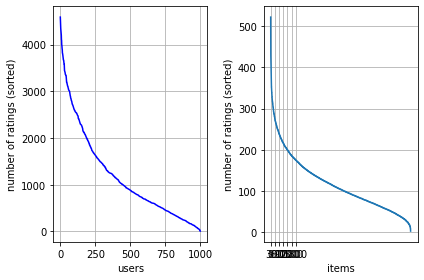

min # of items per user = 8, min # of users per item = 3.


In [169]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [96]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.5):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))
    
    def list_transpose(L):
        """Transforms a row vector into a column."""
        R = []
        for e in L:
            R.append([e])
        return R

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[list_transpose(residual), user] = valid_ratings[residual, user]

        # add to test set
        test[list_transpose(selects), user] = valid_ratings[selects, user]
        
    print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

the shape of original ratings. (# of row, # of col): (3000, 1000)
the shape of valid ratings. (# of row, # of col): (2966, 982)
Total number of nonzero elements in original data:353931
Total number of nonzero elements in train data:214380
Total number of nonzero elements in test data:138842


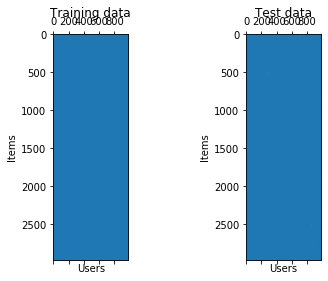

In [97]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=20, p_test=0.5)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [98]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]

    # calculate the global mean
    global_mean_train = nonzero_train.mean()

    # find the non zero ratings in the test
    nonzero_test = test[test.nonzero()].todense()

    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))

baseline_global_mean(train, test)

test RMSE of baseline using the global mean: [[1.11439266]].


### Use the user means as the prediction

In [99]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[:, user_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[:, user_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))

baseline_user_mean(train, test)

test RMSE of the baseline using the user mean: [[1.02631872]].


### Use the item means as the prediction

In [100]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        train_ratings = train[item_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]

        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each movie in the test dataset
        test_ratings = test[item_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
    
baseline_item_mean(train, test)

test RMSE of the baseline using the item mean: [[1.09351351]].


### Learn the Matrix Factorization using ALS

In [101]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    num_item, num_user = train.get_shape()

    # set seed
    np.random.seed(988)
    
    # Initialize randomly
    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)
    
    # Set the first row of item features to the mean of the ratings of that item.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
    
    # Do the same for user features.
    user_nnz = train.getnnz(axis=0)
    user_sum = train.sum(axis=0)

    for ind in range(num_user):
        user_features[0, ind] = user_sum[0, ind] / user_nnz[ind]
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.

In [102]:
def compute_error(data, user_features, item_features):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    nz_row, nz_col = data.nonzero()
    nz = list(zip(nz_row, nz_col))
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        predicted_rating = int(round(user_info.T.dot(item_info))) # To calculate the RMSE as would do the aicrowd platform
        if predicted_rating not in [1, 2, 3, 4, 5]:
            if predicted_rating > 5:
                predicted_rating = 5
            elif predicted_rating < 1:
                predicted_rating = 1
        mse += (data[row, col] - predicted_rating) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [103]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [155]:
from helpers import build_index_groups


def ALS(train, params):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = params['K']   # K in the lecture notes
    lambda_user = params['lambda_user']
    lambda_item = params['lambda_item']
    stop_criterion = params['stop_criterion']
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])
    
    return item_features, user_features

In [118]:
# define initial parameters
params = {
    "K": 50,
    "stop_criterion": 1e-5,
    "lambda_user": 0.1,
    "lambda_item": 0.1,
}

In [119]:
item_features, user_features = ALS(train, params)


start the ALS algorithm...
RMSE on training set: 1.105573241099733.
RMSE on training set: 0.9634494849097929.
RMSE on training set: 0.8888005483670101.
RMSE on training set: 0.8539405593848964.
RMSE on training set: 0.8351477588330521.
RMSE on training set: 0.8237965352024201.
RMSE on training set: 0.8153388853114535.
RMSE on training set: 0.8096782562393149.
RMSE on training set: 0.8052415980062276.
RMSE on training set: 0.8019358051267947.
RMSE on training set: 0.7991885286460465.
RMSE on training set: 0.7971869564710006.
RMSE on training set: 0.7953768364551486.
RMSE on training set: 0.7940855632143069.
RMSE on training set: 0.7928304304366974.
RMSE on training set: 0.7917559644424235.
RMSE on training set: 0.7907537786123915.
RMSE on training set: 0.7901990830881365.
RMSE on training set: 0.7893810820952374.
RMSE on training set: 0.7889170731672199.
RMSE on training set: 0.7884113769475348.
RMSE on training set: 0.7882338627882741.
RMSE on training set: 0.7878550322387134.
RMSE on

K = 50

In [120]:
rmse = compute_error(test, user_features, item_features)
print("test RMSE after running ALS: {v}.".format(v=rmse))

test RMSE after running ALS: 1.0405521303487224.


## Tuning lambda_user

In [127]:
params['lambda_user'] = 0.15

In [128]:
item_features, user_features = ALS(train, params)


start the ALS algorithm...
RMSE on training set: 1.2946404334943493.
RMSE on training set: 1.129164142866568.
RMSE on training set: 1.0647061643217852.
RMSE on training set: 1.0271684868069142.
RMSE on training set: 1.0024319713889838.
RMSE on training set: 0.9867013859142063.
RMSE on training set: 0.9753013891620705.
RMSE on training set: 0.9681705587369988.
RMSE on training set: 0.9626381792780454.
RMSE on training set: 0.9587416536034742.
RMSE on training set: 0.9557643013617113.
RMSE on training set: 0.9534310112229807.
RMSE on training set: 0.9514695671214697.
RMSE on training set: 0.9499780269577734.
RMSE on training set: 0.948828336549846.
RMSE on training set: 0.9477781501812562.
RMSE on training set: 0.9469632699575811.
RMSE on training set: 0.9462807915757727.
RMSE on training set: 0.9457507306074072.
RMSE on training set: 0.9452080349385715.
RMSE on training set: 0.9448600524443306.
RMSE on training set: 0.9446329309289159.
RMSE on training set: 0.9442056957742081.
RMSE on 

In [129]:
rmse = compute_error(test, user_features, item_features)
print("test RMSE after running ALS: {v}.".format(v=rmse))

test RMSE after running ALS: 1.0395583861049025.


In [131]:
lambda_user_list = [0.095,0.1,0.15,0.2]
lambda_user_error = []

In [133]:
for lambda_user in lambda_user_list:
    params['lambda_user'] = lambda_user
    item_features, user_features = ALS(train, params)
    rmse = compute_error(test, user_features, item_features)
    print("test RMSE after running ALS: {v}.\n".format(v=rmse))
    lambda_user_error.append(rmse)


start the ALS algorithm...
RMSE on training set: 1.085551239943284.
RMSE on training set: 0.9401434805233293.
RMSE on training set: 0.8691035515407132.
RMSE on training set: 0.8372368691994729.
RMSE on training set: 0.8188725727032198.
RMSE on training set: 0.8072058623586306.
RMSE on training set: 0.7991622631176382.
RMSE on training set: 0.7929186779572865.
RMSE on training set: 0.7887219305909594.
RMSE on training set: 0.7855158631061135.
RMSE on training set: 0.782690096824254.
RMSE on training set: 0.7806611620837853.
RMSE on training set: 0.7790461849584713.
RMSE on training set: 0.7772748363896999.
RMSE on training set: 0.7763230568337482.
RMSE on training set: 0.7753279959213687.
RMSE on training set: 0.7744159884363285.
RMSE on training set: 0.7734787832373262.
RMSE on training set: 0.7727366517877482.
RMSE on training set: 0.7722475416016824.
RMSE on training set: 0.7714981796344139.
RMSE on training set: 0.7712109327718042.
RMSE on training set: 0.7708781974221037.
RMSE on 

In [134]:
best_lambda_user = lambda_user_list[int(lambda_user_error.index(min(lambda_user_error)))]

In [135]:
print(best_lambda_user)

0.15


In [147]:
params['lambda_user'] = best_lambda_user

## Tuning lambda item

In [159]:
params['lambda_item'] = 0.01

In [157]:
item_features, user_features = ALS(train, params)


start the ALS algorithm...
RMSE on training set: 0.652419124249112.
RMSE on training set: 0.5316944101616854.
RMSE on training set: 0.4692921228376998.
RMSE on training set: 0.43123022986384896.
RMSE on training set: 0.4052436412910037.
RMSE on training set: 0.38650864871957424.
RMSE on training set: 0.372765601267336.
RMSE on training set: 0.3621725449666809.
RMSE on training set: 0.35382705025310135.
RMSE on training set: 0.34706531579318844.
RMSE on training set: 0.34149673574472517.
RMSE on training set: 0.33627307105814025.
RMSE on training set: 0.3314669270443554.
RMSE on training set: 0.32713948772012524.
RMSE on training set: 0.3231801005125342.
RMSE on training set: 0.31952216166041564.
RMSE on training set: 0.31628676373489173.
RMSE on training set: 0.313434906213198.
RMSE on training set: 0.31134442093392883.
RMSE on training set: 0.3092699709274024.
RMSE on training set: 0.3073560923678372.
RMSE on training set: 0.30520105125429126.
RMSE on training set: 0.3034690739915642

In [158]:
rmse = compute_error(test, user_features, item_features)
print("test RMSE after running ALS: {v}.".format(v=rmse))

test RMSE after running ALS: 1.295293333633461.


In [160]:
lambda_item_list = [0.01, 0.08,0.1,0.2,0.3]
lambda_item_error = []

In [161]:
for lambda_item in lambda_item_list:
    params['lambda_item'] = lambda_item
    print(params)
    item_features, user_features = ALS(train, params)
    rmse = compute_error(test, user_features, item_features)
    print("test RMSE after running ALS: {v}.\n".format(v=rmse))
    lambda_item_error.append(rmse)

{'K': 50, 'stop_criterion': 1e-05, 'lambda_user': 0.15, 'lambda_item': 0.01}

start the ALS algorithm...
RMSE on training set: 0.8338565388042788.
RMSE on training set: 0.6555610107596767.
RMSE on training set: 0.5999930030378475.
RMSE on training set: 0.5723965752436729.
RMSE on training set: 0.5568861758860546.
RMSE on training set: 0.5463923868047965.
RMSE on training set: 0.5393508483582634.
RMSE on training set: 0.5340316936282168.
RMSE on training set: 0.5292586792015938.
RMSE on training set: 0.5259875806283619.
RMSE on training set: 0.5230662323472631.
RMSE on training set: 0.5201643478579974.
RMSE on training set: 0.5179221044506314.
RMSE on training set: 0.5158057795349893.
RMSE on training set: 0.5143069267367966.
RMSE on training set: 0.5122894944935782.
RMSE on training set: 0.5110587836292976.
RMSE on training set: 0.5097885027802581.
RMSE on training set: 0.5089093353766935.
RMSE on training set: 0.5077852707056687.
RMSE on training set: 0.5071280324630296.
RMSE on train

In [162]:
best_lambda_item = lambda_item_list[int(lambda_item_error.index(min(lambda_item_error)))]

In [163]:
print(best_lambda_item)

0.1


In [164]:
params['lambda_item'] = best_lambda_item

In [165]:
print(params)

{'K': 50, 'stop_criterion': 1e-05, 'lambda_user': 0.15, 'lambda_item': 0.1}


## Fit over the full data

In [166]:
item_features_full, user_features_full = ALS(ratings_full, params)


start the ALS algorithm...
RMSE on training set: 1.1726405309746673.
RMSE on training set: 1.108821128508325.
RMSE on training set: 1.0794240445974472.
RMSE on training set: 1.0595128339955782.
RMSE on training set: 1.0468460551472827.
RMSE on training set: 1.0387344394929414.
RMSE on training set: 1.0329648236600435.
RMSE on training set: 1.0289223671577747.
RMSE on training set: 1.0259341110931615.
RMSE on training set: 1.023697258164516.
RMSE on training set: 1.0218580213956034.
RMSE on training set: 1.020391489309146.
RMSE on training set: 1.0190875230743592.
RMSE on training set: 1.018101567426348.
RMSE on training set: 1.0171948469944276.
RMSE on training set: 1.0164929615352012.
RMSE on training set: 1.0158662864863277.
RMSE on training set: 1.0153651700434885.
RMSE on training set: 1.014929524878432.
RMSE on training set: 1.014588745985107.
RMSE on training set: 1.014271727236678.
RMSE on training set: 1.0140249954778517.
RMSE on training set: 1.013773175028898.
RMSE on traini

## Record the result into a csv file

In [167]:
from helpers import get_submission_csv

get_submission_csv(item_features_full, user_features_full, path_sample, path_submission)

(10000, 1000)
Submission created successfully!
